In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.utils.generic_utils import Progbar
import time

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./housing.data', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
X = df[['RM']].values
y = df[['MEDV']].values
scx = StandardScaler()
scy = StandardScaler()
X_train = scx.fit_transform(X)
y_train = scy.fit_transform(y)
print(X_train.shape)
print(y_train.shape)

(506, 1)
(506, 1)


In [25]:
import numpy as np
import sys
class NeuralNetMLP(object):
    def __init__(self, n_hidden=30, l2=0., epochs=200, eta=0.001, shuffle=True, minibatch_size=1, seed=None, drop_out = False):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.drop_out = drop_out
  
    def _Relu(self, z):
        return np.maximum(0, np.clip(z,0,1))

    def _dropout(self, X):

        a = np.random.randint(2, size = X.shape)    
        while np.array_equal(X, np.zeros(shape=X.shape)):
          a = np.random.randint(2, shape = X.shape)
        return a*X

    def _forward(self, X):        
        if self.drop_out:
            X = self._dropout(X)
        z_h = np.dot(X, self.w_h) + self.b_h
        
        a_h = self._Relu(z_h)

        z_out = np.dot(a_h, self.w_out) + self.b_out
        # step 4: activation output layer
        a_out = self._Relu(z_out)
        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        cost = np.sum((y_enc - output)**2)
        return cost
    
    def net_input(self, X):
        return X * np.dot(self._Relu(self.w_h), self._Relu(self.w_out))
    
    def predict(self, X):
        return self.net_input(X)
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = 1 # no. of class labels
        n_features = X_train.shape[1]
        ########################
        # Weight initialization
        ########################
        
        self.b_h = np.zeros(self.n_hidden)
      
        #initializer 
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)

        #initializer 
        self.w_out = self.random.normal(loc=0.0, scale=0.1,size=(self.n_hidden, n_output))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': []}
      
        # iterate over training epochs
        for j in range(self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
            
            print('Epoch', j+1,end = ' ')
                       
            #progress_bar = Progbar(target=indices.shape[0])
            start = time.time()
            
            for start_idx in range(0,indices.shape[0] -self.minibatch_size +1,self.minibatch_size):
                batch_idx = indices[start_idx:start_idx+self.minibatch_size]
                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                ##################
                # Backpropagation
                ##################
                
                sigma_out = a_out - y_train[batch_idx]
                relu_derivative_h = np.zeros(len(a_h[0]))
                       
                for i in range(len(a_h[0])):
                    if a_h[0][i] > 0:
                        relu_derivative_h[i] = 1
                    else:
                        relu_derivative_h[i] = 0
                
                sigma_h = (np.dot(sigma_out, self.w_out.T)*relu_derivative_h)
                
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
                delta_w_h = grad_w_h
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                delta_w_out = grad_w_out
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                #progress_bar.update(start_idx)
            #############
            # Evaluation
            #############
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
        
            cost = self._compute_cost(y_train,a_out)
            self.eval_['cost'].append(cost)
            print('cost:', self.eval_['cost'][len(self.eval_['cost'])-1], end = ', ')
            end = time.time()
            print(end-start, 'sec')
        return self

In [66]:
nn = NeuralNetMLP()
nn.n_hidden=20
nn.epochs = 1000
nn.dropout = True
nn.eta = 0.00001
nn.fit(X_train = X_train[:500], y_train = y_train[:500], X_valid = X_train[500:], y_valid = y_train[500:])

Epoch 1 cost: 504.20207208385597, 0.051590919494628906 sec
Epoch 2 cost: 503.8901051101577, 0.05088996887207031 sec
Epoch 3 cost: 503.55790306112203, 0.05408120155334473 sec
Epoch 4 cost: 503.2267543418513, 0.045942068099975586 sec
Epoch 5 cost: 502.896614063638, 0.05628323554992676 sec
Epoch 6 cost: 502.5670976162691, 0.052236318588256836 sec
Epoch 7 cost: 502.2381510014517, 0.0453033447265625 sec
Epoch 8 cost: 501.9100819909909, 0.05606794357299805 sec
Epoch 9 cost: 501.58275236467864, 0.04986405372619629 sec
Epoch 10 cost: 501.25611686336663, 0.05255484580993652 sec
Epoch 11 cost: 500.93012357767304, 0.05030488967895508 sec
Epoch 12 cost: 500.604811632237, 0.05237436294555664 sec
Epoch 13 cost: 500.28008406255486, 0.05069398880004883 sec
Epoch 14 cost: 499.95571151654, 0.05363893508911133 sec
Epoch 15 cost: 499.6319335204931, 0.054531097412109375 sec
Epoch 16 cost: 499.30882598448017, 0.05754542350769043 sec
Epoch 17 cost: 498.98659783808046, 0.049637556076049805 sec
Epoch 18 cost: 

Epoch 144 cost: 462.42597876376294, 0.05162167549133301 sec
Epoch 145 cost: 462.1420633005456, 0.04694247245788574 sec
Epoch 146 cost: 461.85795054491774, 0.0517728328704834 sec
Epoch 147 cost: 461.57412032877994, 0.05188488960266113 sec
Epoch 148 cost: 461.290822775972, 0.05228161811828613 sec
Epoch 149 cost: 461.00734428391826, 0.0564112663269043 sec
Epoch 150 cost: 460.72366173652074, 0.04886007308959961 sec
Epoch 151 cost: 460.43989325073545, 0.04985451698303223 sec
Epoch 152 cost: 460.15582671312643, 0.052848100662231445 sec
Epoch 153 cost: 459.8716701975397, 0.055518388748168945 sec
Epoch 154 cost: 459.5873910784145, 0.050991058349609375 sec
Epoch 155 cost: 459.30293668084073, 0.06467556953430176 sec
Epoch 156 cost: 459.0183663519569, 0.05219578742980957 sec
Epoch 157 cost: 458.73367403558655, 0.05215144157409668 sec
Epoch 158 cost: 458.4487115248595, 0.05357933044433594 sec
Epoch 159 cost: 458.1635097087751, 0.05291604995727539 sec
Epoch 160 cost: 457.8779816379472, 0.0474381446

Epoch 283 cost: 422.08810357448914, 0.05191659927368164 sec
Epoch 284 cost: 421.7886447916738, 0.05140829086303711 sec
Epoch 285 cost: 421.48897313791645, 0.0554041862487793 sec
Epoch 286 cost: 421.18922818162656, 0.054366350173950195 sec
Epoch 287 cost: 420.88918827438005, 0.05986738204956055 sec
Epoch 288 cost: 420.5890063288416, 0.05287742614746094 sec
Epoch 289 cost: 420.28840805769534, 0.054464101791381836 sec
Epoch 290 cost: 419.9900108369709, 0.0516812801361084 sec
Epoch 291 cost: 419.6913649619353, 0.05902528762817383 sec
Epoch 292 cost: 419.39420442308085, 0.05346083641052246 sec
Epoch 293 cost: 419.09730829040416, 0.052744150161743164 sec
Epoch 294 cost: 418.80026471962356, 0.05004239082336426 sec
Epoch 295 cost: 418.5028743068298, 0.05002999305725098 sec
Epoch 296 cost: 418.20556444021526, 0.0581052303314209 sec
Epoch 297 cost: 417.90810244646264, 0.05746030807495117 sec
Epoch 298 cost: 417.61026041542283, 0.04890084266662598 sec
Epoch 299 cost: 417.3122821107688, 0.05203986

Epoch 424 cost: 381.5668019225962, 0.05873990058898926 sec
Epoch 425 cost: 381.2966943314847, 0.05693936347961426 sec
Epoch 426 cost: 381.026892258109, 0.05956387519836426 sec
Epoch 427 cost: 380.7575033869681, 0.06365823745727539 sec
Epoch 428 cost: 380.48854648477766, 0.05782890319824219 sec
Epoch 429 cost: 380.22006628663155, 0.053998708724975586 sec
Epoch 430 cost: 379.95170283029654, 0.05407977104187012 sec
Epoch 431 cost: 379.6835338555509, 0.05362677574157715 sec
Epoch 432 cost: 379.4157316270713, 0.055924415588378906 sec
Epoch 433 cost: 379.1481939323277, 0.05742931365966797 sec
Epoch 434 cost: 378.88084071660074, 0.0584256649017334 sec
Epoch 435 cost: 378.61383761554055, 0.05872464179992676 sec
Epoch 436 cost: 378.3469376400111, 0.05765795707702637 sec
Epoch 437 cost: 378.080209237526, 0.05186271667480469 sec
Epoch 438 cost: 377.81355968282344, 0.05395770072937012 sec
Epoch 439 cost: 377.5472074548812, 0.05484938621520996 sec
Epoch 440 cost: 377.28103302536755, 0.0532059669494

Epoch 562 cost: 350.15628671186016, 0.06474113464355469 sec
Epoch 563 cost: 349.998078160269, 0.06308770179748535 sec
Epoch 564 cost: 349.8407463906659, 0.056836843490600586 sec
Epoch 565 cost: 349.684063035147, 0.0614171028137207 sec
Epoch 566 cost: 349.527729033111, 0.06336617469787598 sec
Epoch 567 cost: 349.3715104867411, 0.06121349334716797 sec
Epoch 568 cost: 349.2154973907779, 0.060051918029785156 sec
Epoch 569 cost: 349.0596311957808, 0.058252811431884766 sec
Epoch 570 cost: 348.90390774599956, 0.06139969825744629 sec
Epoch 571 cost: 348.74837991651816, 0.06244468688964844 sec
Epoch 572 cost: 348.5932345093213, 0.05617809295654297 sec
Epoch 573 cost: 348.4383270077971, 0.06528520584106445 sec
Epoch 574 cost: 348.2834929574218, 0.06651782989501953 sec
Epoch 575 cost: 348.12900599270415, 0.05783247947692871 sec
Epoch 576 cost: 347.9748896315599, 0.057353973388671875 sec
Epoch 577 cost: 347.8239134815363, 0.06386351585388184 sec
Epoch 578 cost: 347.6731842348876, 0.066981077194213

Epoch 702 cost: 336.501638463399, 0.05999302864074707 sec
Epoch 703 cost: 336.4567143340511, 0.06681275367736816 sec
Epoch 704 cost: 336.41191846606716, 0.06301617622375488 sec
Epoch 705 cost: 336.3670913777948, 0.05635499954223633 sec
Epoch 706 cost: 336.322378828517, 0.06244039535522461 sec
Epoch 707 cost: 336.27779546225133, 0.057177066802978516 sec
Epoch 708 cost: 336.2334482117168, 0.0584559440612793 sec
Epoch 709 cost: 336.1897461394825, 0.05513715744018555 sec
Epoch 710 cost: 336.1469370422478, 0.05779886245727539 sec
Epoch 711 cost: 336.1047696655153, 0.060064077377319336 sec
Epoch 712 cost: 336.0628154238723, 0.05974984169006348 sec
Epoch 713 cost: 336.0210360645868, 0.05497336387634277 sec
Epoch 714 cost: 335.97945947747337, 0.05730891227722168 sec
Epoch 715 cost: 335.9381358921423, 0.06188154220581055 sec
Epoch 716 cost: 335.89704716149754, 0.058394432067871094 sec
Epoch 717 cost: 335.8569027685746, 0.06417608261108398 sec
Epoch 718 cost: 335.8199945084028, 0.062646865844726

Epoch 841 cost: 333.4565782895559, 0.0589451789855957 sec
Epoch 842 cost: 333.4433244409248, 0.06286740303039551 sec
Epoch 843 cost: 333.4302972575945, 0.06561112403869629 sec
Epoch 844 cost: 333.41753670139724, 0.05933189392089844 sec
Epoch 845 cost: 333.40491222467995, 0.06065559387207031 sec
Epoch 846 cost: 333.39309147970414, 0.06288933753967285 sec
Epoch 847 cost: 333.3819163096699, 0.05494189262390137 sec
Epoch 848 cost: 333.37046650815216, 0.07059025764465332 sec
Epoch 849 cost: 333.35870747835736, 0.07654237747192383 sec
Epoch 850 cost: 333.347082918998, 0.06383085250854492 sec
Epoch 851 cost: 333.33554311493936, 0.05991530418395996 sec
Epoch 852 cost: 333.3241471526396, 0.061678171157836914 sec
Epoch 853 cost: 333.31286264618495, 0.06157541275024414 sec
Epoch 854 cost: 333.3016858541711, 0.058417558670043945 sec
Epoch 855 cost: 333.29063283784933, 0.060999155044555664 sec
Epoch 856 cost: 333.27969665141586, 0.062061309814453125 sec
Epoch 857 cost: 333.2688758598373, 0.05636572

Epoch 979 cost: 333.1123574947156, 0.06242799758911133 sec
Epoch 980 cost: 333.1113769062747, 0.062290191650390625 sec
Epoch 981 cost: 333.10987056886097, 0.058762311935424805 sec
Epoch 982 cost: 333.1083377636604, 0.055216312408447266 sec
Epoch 983 cost: 333.10685400994936, 0.058859825134277344 sec
Epoch 984 cost: 333.10555798519033, 0.060887813568115234 sec
Epoch 985 cost: 333.1044148717363, 0.05649852752685547 sec
Epoch 986 cost: 333.1033244983932, 0.05603480339050293 sec
Epoch 987 cost: 333.1024995380563, 0.06375932693481445 sec
Epoch 988 cost: 333.101705818116, 0.06920003890991211 sec
Epoch 989 cost: 333.1010306338076, 0.08240294456481934 sec
Epoch 990 cost: 333.1003995570299, 0.07950282096862793 sec
Epoch 991 cost: 333.0997822514575, 0.0716702938079834 sec
Epoch 992 cost: 333.09920079961216, 0.06808114051818848 sec
Epoch 993 cost: 333.0986533993356, 0.09431838989257812 sec
Epoch 994 cost: 333.0972586446103, 0.08559966087341309 sec
Epoch 995 cost: 333.09549733144956, 0.09108066558

In [67]:
y_pred = nn.predict(X_train)

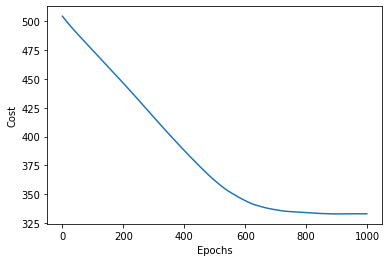

In [68]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
if nn.dropout == True:
    plt.savefig('cost_vs_epoch_with_Dropout.png')
elif nn.dropout == False:
    plt.savefig('cost_vs_epoch.png')
plt.show()

In [69]:
print(nn.eval_['cost'][len(nn.eval_['cost'])-1])

333.095829612187


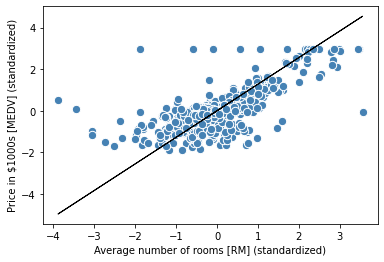

In [70]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=1)

lin_regplot(X_train, y_train, nn)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
if nn.dropout == True:
    plt.savefig('predictdo.png')
elif nn.dropout == False:
    plt.savefig('predict.png')
plt.show()